## Modeling Survival on the Titanic

In [94]:
import pandas as pd
import numpy as np
import re
import pickle

In [95]:
import plotly as py
import plotly.graph_objs as go

In [96]:
from sklearn import svm
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

In [97]:
# Define the color palette 
Viridis=[
"#440154", "#440558", "#450a5c", "#450e60", "#451465", "#461969",
"#461d6d", "#462372", "#472775", "#472c7a", "#46307c", "#45337d",
"#433880", "#423c81", "#404184", "#3f4686", "#3d4a88", "#3c4f8a",
"#3b518b", "#39558b", "#37598c", "#365c8c", "#34608c", "#33638d",
"#31678d", "#2f6b8d", "#2d6e8e", "#2c718e", "#2b748e", "#29788e",
"#287c8e", "#277f8e", "#25848d", "#24878d", "#238b8d", "#218f8d",
"#21918d", "#22958b", "#23988a", "#239b89", "#249f87", "#25a186",
"#25a584", "#26a883", "#27ab82", "#29ae80", "#2eb17d", "#35b479",
"#3cb875", "#42bb72", "#49be6e", "#4ec16b", "#55c467", "#5cc863",
"#61c960", "#6bcc5a", "#72ce55", "#7cd04f", "#85d349", "#8dd544",
"#97d73e", "#9ed93a", "#a8db34", "#b0dd31", "#b8de30", "#c3df2e",
"#cbe02d", "#d6e22b", "#e1e329", "#eae428", "#f5e626", "#fde725"]
# source: https://bhaskarvk.github.io/colormap/reference/colormap.html

### Read in the titanic dataset

In [98]:
df = pd.read_csv('resources/titanic.csv')
# df = pd.read_csv("https://raw.githubusercontent.com/austinlasseter/plotly_dash_tutorial/master/00%20resources/titanic.csv")
print(df.shape)
df.head()

(712, 8)


,Survived,Pclass,Sex,Age,Fare,Embarked,Name,SibSp
0,0,3,male,22.0,7.2500,Southampton,"Braund, Mr. Owen Harris",1
1,1,1,female,38.0,71.2833,Cherbourg,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1
2,1,3,female,26.0,7.9250,Southampton,"Heikkinen, Miss. Laina",0
3,1,1,female,35.0,53.1000,Southampton,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1
4,0,3,male,35.0,8.0500,Southampton,"Allen, Mr. William Henry",0


### Features

In [99]:
# Make some dummies for sex.
df = pd.get_dummies(df, prefix='', prefix_sep='', columns=['Sex'])

In [100]:
# Make some dummies Passenger's cabin class
df = pd.get_dummies(df, prefix='Cabin Class', prefix_sep=' ', columns=['Pclass'])

In [101]:
# Make some dummies Passenger's embarkation
df = pd.get_dummies(df, prefix='', prefix_sep='', columns=['Embarked'])

In [102]:
df['family_size'] = df['SibSp']+1
df['single'] = df['family_size'].map(lambda x : 1 if x == 1 else 0)
df['small_family'] = df['family_size'].map(lambda x : 1 if (2 <= x <= 4) else 0)
df['large_family'] = df['family_size'].map(lambda x : 1 if 5 <= x else 0)


In [103]:
df.head()

,Survived,Age,Fare,Name,SibSp,female,male,Cabin Class 1,Cabin Class 2,Cabin Class 3,Cherbourg,Queenstown,Southampton,family_size,single,small_family,large_family
0,0,22.0,7.2500,"Braund, Mr. Owen Harris",1,0,1,0,0,1,0,0,1,2,0,1,0
1,1,38.0,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,1,0,1,0,0,1,0,0,2,0,1,0
2,1,26.0,7.9250,"Heikkinen, Miss. Laina",0,1,0,0,0,1,0,0,1,1,1,0,0
3,1,35.0,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,1,0,1,0,0,0,0,1,2,0,1,0
4,0,35.0,8.0500,"Allen, Mr. William Henry",0,0,1,0,0,1,0,0,1,1,1,0,0


In [104]:
# Siblings and Spouses
df=df.rename(columns={'SibSp':'Siblings and Spouses'})
df['Siblings and Spouses'].value_counts()

0    469
1    183
2     25
4     18
3     12
5      5
Name: Siblings and Spouses, dtype: int64

In [105]:
# age requires binning
print(df.Age.describe())
print(df.Age.describe()['25%'])

count    712.000000
mean      29.642093
std       14.492933
min        0.420000
25%       20.000000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64
20.0


In [106]:
# Age
bins=[1, 20, 28, 38, 80]
df['age_binned']=pd.cut(df['Age'], bins)
df['age_binned'].value_counts().sort_index()

(1, 20]     165
(20, 28]    183
(28, 38]    174
(38, 80]    176
Name: age_binned, dtype: int64

In [107]:
df = pd.get_dummies(df, prefix='Age', prefix_sep=' ', columns=['age_binned'])
df.head(2)

,Survived,Age,Fare,Name,Siblings and Spouses,female,male,Cabin Class 1,Cabin Class 2,Cabin Class 3,...,Queenstown,Southampton,family_size,single,small_family,large_family,"Age (1, 20]","Age (20, 28]","Age (28, 38]","Age (38, 80]"
0,0,22.0,7.2500,"Braund, Mr. Owen Harris",1,0,1,0,0,1,...,0,1,2,0,1,0,0,1,0,0
1,1,38.0,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,1,0,1,0,0,...,0,0,2,0,1,0,0,0,1,0


In [108]:
# Name
df['Last Name']=df['Name'].apply(lambda x: x.split(',')[0])
df['First Name']=df['Name'].apply(lambda x: x.split(',')[1])
df['Title']=df['First Name'].apply(lambda x: x.split('.')[0])

In [109]:
# Title
print(df['Title'].value_counts())
df['Mr.']=np.where((df['Title']==' Mr')|(df['Title']==' Master')|(df['Title']==' Ms'), 1, 0) # Ms is actually monsieur
df['Mrs.']=np.where((df['Title']==' Mrs')|(df['Title']==' Mme'), 1, 0)
df['Miss']=np.where((df['Title']==' Miss')|(df['Title']==' Mlle'), 1, 0)
df['VIP']=np.where((df['Mr.']==0)&(df['Mrs.']==0)&(df['Miss']==0), 1, 0)

 Mr              398
 Miss            145
 Mrs             107
 Master           36
 Rev               6
 Dr                6
 Mlle              2
 Major             2
 Col               2
 the Countess      1
 Capt              1
 Ms                1
 Sir               1
 Lady              1
 Mme               1
 Don               1
 Jonkheer          1
Name: Title, dtype: int64


In [110]:
df['VIP'].value_counts()

0    690
1     22
Name: VIP, dtype: int64

In [111]:
# Check for missing values as they will skew the regression
print(df.shape)
df = df.dropna()
print(df.shape)

(712, 28)
(712, 28)


In [112]:
# What are the possible features?
df.columns

Index(['Survived', 'Age', 'Fare', 'Name', 'Siblings and Spouses', 'female',
       'male', 'Cabin Class 1', 'Cabin Class 2', 'Cabin Class 3', 'Cherbourg',
       'Queenstown', 'Southampton', 'family_size', 'single', 'small_family',
       'large_family', 'Age (1, 20]', 'Age (20, 28]', 'Age (28, 38]',
       'Age (38, 80]', 'Last Name', 'First Name', 'Title', 'Mr.', 'Mrs.',
       'Miss', 'VIP'],
      dtype='object')

In [113]:
# Turns out that fare doesn't add any significant or meaningful coefficient to the final model, so we're dropping it.
feature_cols=list(df.columns)
for item in ['Survived', 'Fare', 'Cabin Class 1', 'Southampton', 'male', 'Age',  'Age (1, 20]', 'Last Name', 'First Name', 'Title', 'Mr.','family_size']:
    feature_cols.remove(item)
print(feature_cols)

['Name', 'Siblings and Spouses', 'female', 'Cabin Class 2', 'Cabin Class 3', 'Cherbourg', 'Queenstown', 'single', 'small_family', 'large_family', 'Age (20, 28]', 'Age (28, 38]', 'Age (38, 80]', 'Mrs.', 'Miss', 'VIP']


In [114]:
# Select our features
X = df[feature_cols]
y = df.Survived

### Modeling

In [115]:
# Train-test split
X_train1, X_test1, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)

In [116]:
X_train1.columns

Index(['Name', 'Siblings and Spouses', 'female', 'Cabin Class 2',
       'Cabin Class 3', 'Cherbourg', 'Queenstown', 'single', 'small_family',
       'large_family', 'Age (20, 28]', 'Age (28, 38]', 'Age (38, 80]', 'Mrs.',
       'Miss', 'VIP'],
      dtype='object')

In [117]:
# Remove the names, we'll save those for later use.
X_train=X_train1.drop('Name', axis=1)
X_test=X_test1.drop('Name', axis=1)

In [118]:
X_train.columns

Index(['Siblings and Spouses', 'female', 'Cabin Class 2', 'Cabin Class 3',
       'Cherbourg', 'Queenstown', 'single', 'small_family', 'large_family',
       'Age (20, 28]', 'Age (28, 38]', 'Age (38, 80]', 'Mrs.', 'Miss', 'VIP'],
      dtype='object')

In [119]:
gnb = GaussianNB()
# Fit on the training data
gnb_model = gnb.fit(X_train, y_train)
# Predict on the testing data
predictions=gnb_model.predict(X_test)
probabilities = gnb_model.predict_proba(X_test)[:,1]
# Calculate the roc-auc score
auc_nb=metrics.roc_auc_score(y_test, predictions)
acc_nb = metrics.accuracy_score(y_test, predictions)
f1_nb = metrics.f1_score(y_test, predictions)
# Display
print('F1 Score', "%.4f" % round(f1_nb,4))
print('Accuracy', "%.4f" % round(acc_nb,4))
print('AUC Score', "%.4f" % round(auc_nb,4))

F1 Score 0.6838
Accuracy 0.7413
AUC Score 0.7300


In [120]:
knn = KNeighborsClassifier(n_neighbors=7)
# Fit on the training data
knn_model=knn.fit(X_train, y_train)
# Predict on the testing data
predictions=knn_model.predict(X_test)
probabilities = knn_model.predict_proba(X_test)[:,1]
# Calculate the roc-auc score
auc_knn=metrics.roc_auc_score(y_test, predictions)
acc_knn = metrics.accuracy_score(y_test, predictions)
f1_knn = metrics.f1_score(y_test, predictions)
# Display
print('F1 Score', "%.4f" % round(f1_knn,4))
print('Accuracy', "%.4f" % round(acc_knn,4))
print('AUC Score', "%.4f" % round(auc_knn,4))

F1 Score 0.6372
Accuracy 0.7133
AUC Score 0.6982


In [121]:
rf = RandomForestClassifier()
# Fit on the training data
rf_model=rf.fit(X_train, y_train)
# Predict on the testing data
predictions=rf_model.predict(X_test)
probabilities = rf_model.predict_proba(X_test)[:,1]
# Calculate the roc-auc score
auc_rf=metrics.roc_auc_score(y_test, predictions)
acc_rf = metrics.accuracy_score(y_test, predictions)
f1_rf = metrics.f1_score(y_test, predictions)
# Display
print('F1 Score', "%.4f" % round(f1_rf,4))
print('Accuracy', "%.4f" % round(acc_rf,4))
print('AUC Score', "%.4f" % round(auc_rf,4))

F1 Score 0.6415
Accuracy 0.7343
AUC Score 0.7136


In [122]:
logreg = LogisticRegression()
# Fit on the training data
log_model=logreg.fit(X_train, y_train)
# Predict on the testing data
predictions=log_model.predict(X_test)
probabilities = log_model.predict_proba(X_test)[:,1]
# Calculate the roc-auc score
auc_log=metrics.roc_auc_score(y_test, predictions)
acc_log = metrics.accuracy_score(y_test, predictions)
f1_log = metrics.f1_score(y_test, predictions)
# Display
print('F1 Score', "%.4f" % round(f1_log,4))
print('Accuracy', "%.4f" % round(acc_log,4))
print('AUC Score', "%.4f" % round(auc_log,4))

F1 Score 0.7227
Accuracy 0.7692
AUC Score 0.7600


### Comparison of Four Models

In [123]:
# create lists from the metrics we produced.
f1=[f1_nb, f1_log, f1_knn, f1_rf]
acc=[acc_nb, acc_log, acc_knn, acc_rf]
auc=[auc_nb, auc_log, auc_knn, auc_rf]
# Define a function that will round our metrics.
def rounder(metric):
    scores_list=[]
    for score in metric:
        scores_list.append(round(float(score*100),1))
    return scores_list
# Apply it to each of the three lists.
f1_scores=rounder(f1)
acc_scores=rounder(acc)
auc_scores=rounder(auc)
score_types=['F1 score', 'Accuracy', 'AUC score']

In [124]:
# Comparison of model metrics
models=['naive bayes', 'logistic regression', 'k-nearest neighbors', 'random forest']
index=['F1 score', 'Accuracy', 'AUC score']
compare_models=pd.DataFrame([f1_scores, acc_scores, auc_scores], index=index, columns=models)
compare_models

,naive bayes,logistic regression,k-nearest neighbors,random forest
F1 score,68.4,72.3,63.7,64.2
Accuracy,74.1,76.9,71.3,73.4
AUC score,73.0,76.0,69.8,71.4


In [125]:
# save to csv, for later use by plotly dash app.
compare_models.to_csv('resources/compare_models.csv', index=True)
pd.read_csv('resources/compare_models.csv', index_col=0)

,naive bayes,logistic regression,k-nearest neighbors,random forest
F1 score,68.4,72.3,63.7,64.2
Accuracy,74.1,76.9,71.3,73.4
AUC score,73.0,76.0,69.8,71.4


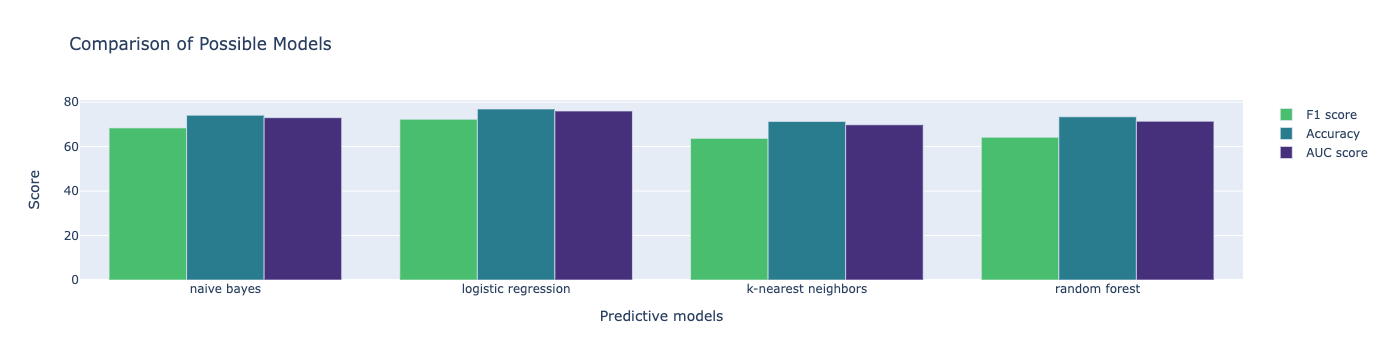

In [126]:
# Let's display that with plotly.
mydata1 = go.Bar(
    x=compare_models.loc['F1 score'].index,
    y=compare_models.loc['F1 score'],
    name=compare_models.index[0],
    marker=dict(color=Viridis[50])
)
mydata2 = go.Bar(
    x=compare_models.loc['Accuracy'].index,
    y=compare_models.loc['Accuracy'],
    name=compare_models.index[1],
    marker=dict(color=Viridis[30])
)
mydata3 = go.Bar(
    x=compare_models.loc['AUC score'].index,
    y=compare_models.loc['AUC score'],
    name=compare_models.index[2],
    marker=dict(color=Viridis[10])
)
mylayout = go.Layout(
    title='Comparison of Possible Models',
    xaxis = dict(title = 'Predictive models'), # x-axis label
    yaxis = dict(title = 'Score'), # y-axis label
    
)
fig = go.Figure(data=[mydata1, mydata2, mydata3], layout=mylayout)
fig

## Tuning the Logistic Classifier
Note: The gridsearch step is included here for completeness sake, as this is a smart inclusion in any iteration of possible models. But for the sake of speed (this notebook was run multiple times during development) I've kept my gridsearch to a bare-bones placeholder. A more complete project would use a broader grid.

In [127]:
# Create regularization penalty space (l1=ridge, l2=lasso)
penalty = ['l1', 'l2'] 

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty, max_iter=[3000])

# Create grid search using 5-fold cross validation
grid_lr = GridSearchCV(LogisticRegression(), hyperparameters, cv=5,  n_jobs = 1, verbose=0)
grid_lr.fit(X_train, y_train)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/studio-lab-user/.conda/envs/default/lib/pyt

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=1,
             param_grid={'C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]),
                         'max_iter': [3000], 'penalty': ['l1', 'l2']})

In [128]:
print(grid_lr.best_params_)

log_model = grid_lr

{'C': 2.7825594022071245, 'max_iter': 3000, 'penalty': 'l2'}


In [129]:
# Predict on the testing data

predictions=log_model.predict(X_test)
probabilities = log_model.predict_proba(X_test)[:,1]

In [130]:
predictions=log_model.predict(X_test)
probabilities = log_model.predict_proba(X_test)[:,1]
# Calculate the roc-auc score
auc_log=metrics.roc_auc_score(y_test, predictions)
acc_log = metrics.accuracy_score(y_test, predictions)
f1_log = metrics.f1_score(y_test, predictions)
# Display
print('F1 Score', "%.4f" % round(f1_log,4))
print('Accuracy', "%.4f" % round(acc_log,4))
print('AUC Score', "%.4f" % round(auc_log,4))

F1 Score 0.7288
Accuracy 0.7762
AUC Score 0.7663


In [131]:
# Pickle the final model for use in the plotly dash app.
file = open('resources/final_logreg_model.pkl', 'wb')
pickle.dump(log_model, file)
file.close()

## RandomForest Grid Search

In [132]:
grid_values = {'max_features': [4, 5, 6, 7, 8],
              'max_depth': [3, 5,  7, 11, 13],
               'n_estimators':[25, 50,100,150]
              }

In [133]:
# grid search for optimal hyperparameters
model = RandomForestClassifier(random_state=42, 
                               n_jobs=4)
rf = GridSearchCV(model, param_grid=grid_values, scoring='accuracy', cv=5)
rf.fit(X_train,y_train)
print(rf.best_params_)
print(rf.best_score_)

{'max_depth': 5, 'max_features': 4, 'n_estimators': 25}
0.803182735600062


In [134]:
# Predict on the testing data
predictions=rf.predict(X_test)
# Calculate the roc-auc score
auc_rf=metrics.roc_auc_score(y_test, predictions)
acc_rf = metrics.accuracy_score(y_test, predictions)
f1_rf = metrics.f1_score(y_test, predictions)
# Display
print('F1 Score', "%.4f" % round(f1_rf,4))
print('Accuracy', "%.4f" % round(acc_rf,4))
print('AUC Score', "%.4f" % round(auc_rf,4))

F1 Score 0.6909
Accuracy 0.7622
AUC Score 0.7453


### RF get outperformed by Logistic reg even in Grid search

#### DECISION TREE?

In [42]:
parametree = {
    "criterion":["entropy","gini"],
    "max_depth":range(2,10),
    "min_samples_split":range(2,5),
    "min_samples_leaf":range(1,5)
}
model = DecisionTreeClassifier(random_state = 42)
dectree = GridSearchCV(model, param_grid=parametree, cv=5, error_score='raise')
dectree.fit(X_train, y_train)
print(dectree.best_params_)
print(dectree.best_score_)

{'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.8013662474771


In [43]:
# Predict on the testing data

predictions=dectree.predict(X_test)

auc_dectree=metrics.roc_auc_score(y_test, predictions)
acc_dectree = metrics.accuracy_score(y_test, predictions)
f1_dectree = metrics.f1_score(y_test, predictions)
# Display
print('F1 Score', "%.4f" % round(f1_dectree,4))
print('Accuracy', "%.4f" % round(acc_dectree,4))
print('AUC Score', "%.4f" % round(auc_dectree,4))

F1 Score 0.6847
Accuracy 0.7552
AUC Score 0.7391


In [44]:
# Pickle the final model for use in the plotly dash app.
file = open('resources/final_dectree_model.pkl', 'wb')
pickle.dump(dectree, file)
file.close()

In [135]:
# Pickle the final model for use in the plotly dash app.
file = open('resources/final_rf_model.pkl', 'wb')
pickle.dump(rf, file)
file.close()

In [136]:
probabilities = rf.predict_proba(X_test)[:,1]

## Final Model Metrics

In [137]:
# Full list of metrics
def model_metrics(y_test, predictions):
    '''
    Calculate 5 standard model metrics
    Return a dictionary with the metrics
    '''
    f1 = metrics.f1_score(y_test, predictions)
    accuracy = metrics.accuracy_score(y_test, predictions)
    error = 1 - accuracy
    precision = metrics.precision_score(y_test, predictions)
    recall = metrics.recall_score(y_test, predictions)
    rocauc =  metrics.roc_auc_score(y_test, predictions)
    return {'precision': precision, 'recall': recall,'f1 score':f1, 'accuracy': accuracy, 'error rate': error,  'ROC-AUC': rocauc}

eval_scores=model_metrics(y_test, predictions)
eval_scores

{'precision': 0.8085106382978723,
 'recall': 0.6031746031746031,
 'f1 score': 0.6909090909090909,
 'accuracy': 0.7622377622377622,
 'error rate': 0.23776223776223782,
 'ROC-AUC': 0.7453373015873016}

In [138]:
# Round the y values.
y_vals=[]
for val in list(eval_scores.values()):
    y_vals.append(round(float(val*100),1))
y_vals    
# Write over the previous dictionary with the rounded values.
eval_scores=dict(zip(eval_scores.keys(), y_vals))
print(eval_scores)

{'precision': 80.9, 'recall': 60.3, 'f1 score': 69.1, 'accuracy': 76.2, 'error rate': 23.8, 'ROC-AUC': 74.5}


In [139]:
# Now save that dictionary to a pickle file, for later use in plotly dash app
file = open('resources/eval_scores.pkl', 'wb')
pickle.dump(eval_scores, file)
file.close()

In [140]:
# And here's a reminder of how to read that back in again, just in case this is unfamiliar:
file = open('resources/eval_scores.pkl', 'rb')
evals=pickle.load(file)
file.close()
evals

{'precision': 80.9,
 'recall': 60.3,
 'f1 score': 69.1,
 'accuracy': 76.2,
 'error rate': 23.8,
 'ROC-AUC': 74.5}

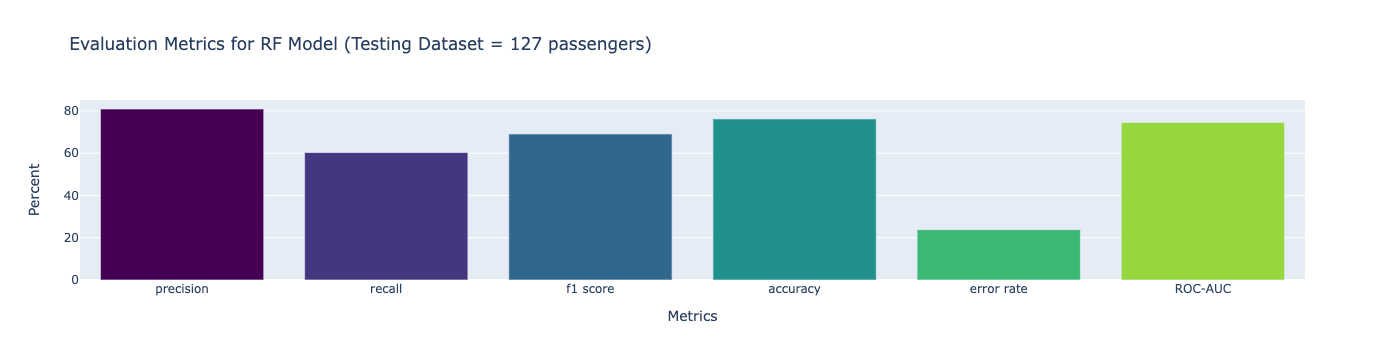

In [141]:
# Convert that into a visualization.
mydata = [go.Bar(
    x=list(evals.keys()),
    y=list(evals.values()),
    marker=dict(color=Viridis[::12])
)]

mylayout = go.Layout(
    title='Evaluation Metrics for RF Model (Testing Dataset = 127 passengers)',
    xaxis = {'title': 'Metrics'},
    yaxis = {'title': 'Percent'}, 

)
fig = go.Figure(data=mydata, layout=mylayout)
fig

In [142]:
FPR, TPR, _ = roc_curve(y_test, probabilities)
FPR

array([0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.0125, 0.0125, 0.025 , 0.025 , 0.0625, 0.0625, 0.075 , 0.1   ,
       0.1   , 0.125 , 0.125 , 0.1625, 0.175 , 0.1875, 0.1875, 0.2125,
       0.2125, 0.2125, 0.25  , 0.25  , 0.275 , 0.2875, 0.325 , 0.325 ,
       0.3625, 0.425 , 0.4375, 0.4375, 0.4625, 0.4875, 0.4875, 0.5   ,
       0.525 , 0.5375, 0.575 , 0.5875, 0.6125, 0.7625, 0.825 , 0.85  ,
       0.8625, 0.9125, 0.925 , 0.925 , 0.95  , 0.9875, 1.    ])

In [143]:
roc_score=round(100*roc_auc_score(y_test, predictions),1)
roc_score

74.5

In [144]:
roc_dict={'FPR':list(FPR), 
          'TPR':list(TPR),
          'y_test':list(y_test), 
          'predictions':[int(i) for i in predictions]
         }

In [145]:
# Save everything we need to reproduce the ROC-AUC figure in plotly dash.
import json
with open('resources/roc_dict.json', 'w') as f:
    json.dump(roc_dict, f)

In [146]:
with open('resources/roc_dict.json') as json_file:
    roc_dict = json.load(json_file)
FPR=roc_dict['FPR']
TPR=roc_dict['TPR']
y_test=pd.Series(roc_dict['y_test'])
predictions=roc_dict['predictions']

In [46]:
# # Save everything we need to reproduce the ROC-AUC figure in plotly dash.
# import json
# file = open('resources/FPR.json', 'wb')
# json.dump(FPR, file)
# file.close()

# file = open('resources/TPR.pkl', 'wb')
# pickle.dump(TPR, file)
# file.close()

# file = open('resources/y_test.pkl', 'wb')
# pickle.dump(y_test, file)
# file.close()

# file = open('resources/predictions.pkl', 'wb')
# pickle.dump(predictions, file)
# file.close()

In [147]:
# ROC-AUC figure

roc_score=round(100*roc_auc_score(y_test, predictions),1)
trace0=go.Scatter(
        x=FPR, 
        y=TPR,
        mode='lines',
        name=f'AUC: {roc_score}',
        marker=dict(color=Viridis[10])
        )
trace1=go.Scatter(
        x=[0,1], 
        y=[0,1],
        mode='lines',
        name='Baseline Area: 50.0',
    marker=dict(color=Viridis[50])
        )
layout=go.Layout(
    title='Receiver Operating Characteristic (ROC): Area Under Curve',
    xaxis={'title': 'False Positive Rate (100-Specificity)','scaleratio': 1,'scaleanchor': 'y'},
    yaxis={'title': 'True Positive Rate (Sensitivity)'}
    )
data=[trace0, trace1]
fig = dict(data=data, layout=layout)
fig

{'data': [Scatter({
      'marker': {'color': '#46307c'},
      'mode': 'lines',
      'name': 'AUC: 74.5',
      'x': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0125, 0.0125, 0.025, 0.025,
            0.0625, 0.0625, 0.075, 0.1, 0.1, 0.125, 0.125, 0.1625, 0.175, 0.1875,
            0.1875, 0.2125, 0.2125, 0.2125, 0.25, 0.25, 0.275, 0.2875, 0.325, 0.325,
            0.3625, 0.425, 0.4375, 0.4375, 0.4625, 0.4875, 0.4875, 0.5, 0.525,
            0.5375, 0.575, 0.5875, 0.6125, 0.7625, 0.825, 0.85, 0.8625, 0.9125,
            0.925, 0.925, 0.95, 0.9875, 1.0],
      'y': [0.0, 0.015873015873015872, 0.1111111111111111, 0.15873015873015872,
            0.19047619047619047, 0.23809523809523808, 0.3333333333333333,
            0.36507936507936506, 0.36507936507936506, 0.3968253968253968,
            0.42857142857142855, 0.47619047619047616, 0.47619047619047616,
            0.5238095238095238, 0.5396825396825397, 0.5714285714285714,
            0.6031746031746031, 0.6031746031746031, 0.634920634

In [148]:
# A confusion matrix tells us our false positives and false negatives:
matrix=confusion_matrix(y_test, predictions)
print(matrix)
cm=pd.DataFrame(matrix, columns=['pred: survival', 'pred: death'])
cm[f'n={len(y_test)}']=['actual: survival', 'actual: death']
cm=cm[[f'n={len(y_test)}', 'pred: survival', 'pred: death']]
cm

[[71  9]
 [25 38]]


,n=143,pred: survival,pred: death
0,actual: survival,71,9
1,actual: death,25,38


In [149]:
# Save cm dataframe to a pickle file, for later use in plotly dash app
cm.to_csv('resources/confusion_matrix.csv', index=False)
cm=pd.read_csv('resources/confusion_matrix.csv')
cm

,n=143,pred: survival,pred: death
0,actual: survival,71,9
1,actual: death,25,38


In [150]:
# Display the confusion matrix as a formatted table with Plotly
trace = go.Table(
    header=dict(values=cm.columns,
                line = dict(color='#7D7F80'),
                fill = dict(color=Viridis[55]),
                align = ['left'] * 5),
    cells=dict(values=[cm[f'n={len(y_test)}'], cm['pred: survival'], cm['pred: death']],
               line = dict(color='#7D7F80'),
               fill = dict(color='white'),
               align = ['left'] * 5))

layout = go.Layout(
    title = f'Confusion Matrix:RF Model (Testing Dataset)'
)

data = [trace]
fig = dict(data=data, layout=layout)
fig

{'data': [Table({
      'cells': {'align': [left, left, left, left, left],
                'fill': {'color': 'white'},
                'line': {'color': '#7D7F80'},
                'values': [['actual: survival', 'actual: death'], [71, 25], [9, 38]]},
      'header': {'align': [left, left, left, left, left],
                 'fill': {'color': '#6bcc5a'},
                 'line': {'color': '#7D7F80'},
                 'values': array(['n=143', 'pred: survival', 'pred: death'], dtype=object)}
  })],
 'layout': Layout({
     'title': {'text': 'Confusion Matrix:RF Model (Testing Dataset)'}
 })}

DecisionTreeClassifier(max_depth=4, random_state=42)

In [65]:
# Feature importance (Logistic Regression)
coeffs1=pd.DataFrame(list(zip(list(X_train.columns), log_model.coef_[0])), columns=['feature', 'coefficient'])
coeffs=coeffs1.sort_values(by='coefficient', ascending=False)

# Format the coefficients.
y_vals=[]
for val in list(coeffs['coefficient']):
    y_vals.append(round(float(val),2))
y_vals

coeffs['coefficient']=y_vals
coeffs

AttributeError: 'GridSearchCV' object has no attribute 'coef_'

In [52]:
# save the results to a csv file, for later use by plotly dash app.
coeffs.to_csv('resources/coefficients.csv', index=False)

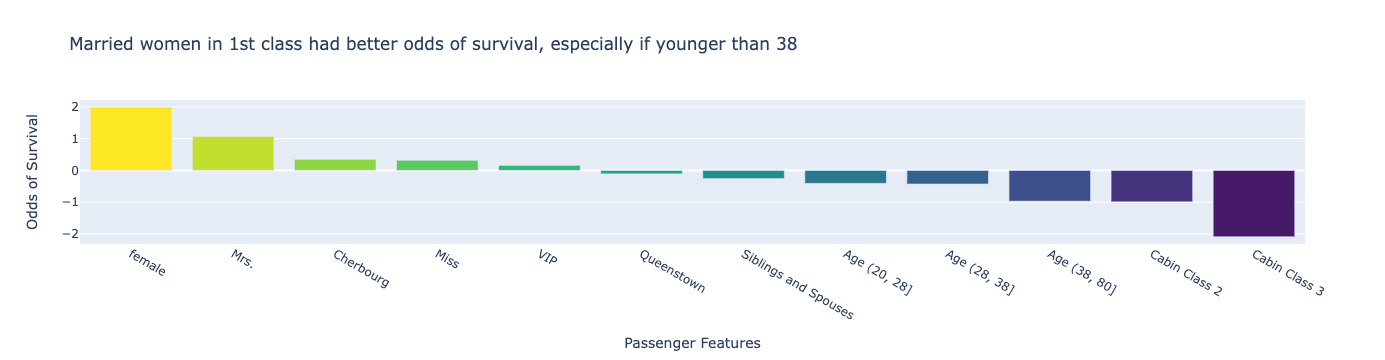

In [53]:
# Let's display that with Plotly.
mydata = [go.Bar(
    x=coeffs['feature'],
    y=coeffs['coefficient'],
    marker=dict(color=Viridis[::-6])
)]

mylayout = go.Layout(
    title='Married women in 1st class had better odds of survival, especially if younger than 38',
    xaxis = {'title': 'Passenger Features'},
    yaxis = {'title': 'Odds of Survival'}, 

)
fig = go.Figure(data=mydata, layout=mylayout)
fig

In [151]:
print(len(probabilities))
print(len(predictions))
print(len(y_test))
print(len(X_test1))

143
143
143
143


In [152]:
X_test1=X_test1.reset_index(drop=True)
y_test=y_test.reset_index(drop=True)
probs=pd.DataFrame(probabilities, columns=['survival_prob'])

In [153]:
# Merge back in the names
final=pd.concat([X_test1, y_test, probs], axis=1)
final.rename(columns={0: "Survived"},inplace=True)

In [154]:
final.shape

(143, 18)

In [155]:
final.head()

,Name,Siblings and Spouses,female,Cabin Class 2,Cabin Class 3,Cherbourg,Queenstown,single,small_family,large_family,"Age (20, 28]","Age (28, 38]","Age (38, 80]",Mrs.,Miss,VIP,Survived,survival_prob
0,"Sagesser, Mlle. Emma",0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0.880074
1,"Eustis, Miss. Elizabeth Mussey",1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0.915561
2,"Taussig, Mr. Emil",1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0.464524
3,"Ryerson, Miss. Emily Borie",2,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0.903598
4,"Sharp, Mr. Percival James R",0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0.148948


In [156]:
final.to_csv('resources/final_probs.csv', index=False)

In [157]:
list(final.columns)

['Name',
 'Siblings and Spouses',
 'female',
 'Cabin Class 2',
 'Cabin Class 3',
 'Cherbourg',
 'Queenstown',
 'single',
 'small_family',
 'large_family',
 'Age (20, 28]',
 'Age (28, 38]',
 'Age (38, 80]',
 'Mrs.',
 'Miss',
 'VIP',
 'Survived',
 'survival_prob']

In [158]:
mydata=final.drop(['survival_prob'], axis=1)
table=[go.Table(
        header=dict(values=list(mydata.columns)),
        cells=dict(values=list(mydata.loc[5])))]
table

[Table({
     'cells': {'values': ['Thayer, Mr. John Borland Jr', 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]},
     'header': {'values': [Name, Siblings and Spouses, female, Cabin Class 2, Cabin
                           Class 3, Cherbourg, Queenstown, single, small_family,
                           large_family, Age (20, 28], Age (28, 38], Age (38, 80],
                           Mrs., Miss, VIP, Survived]}
 })]

## Exploring individual predictions

In [159]:
value='Sharp, Mr. Percival James R'
survival=final.loc[3, 'survival_prob']
survival

0.9035976820633465

In [160]:
names=df['Name'].values
names[:5]

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry'], dtype=object)

In [161]:
indexs=df['Name'].index.values
indexs[:5]

array([0, 1, 2, 3, 4])

In [162]:
names=df['Name'].values
index=df['Name'].index.values
nameslist = list(zip(indexs, names))
print(nameslist[5])
print(nameslist[5][0])
print(nameslist[5][1])

(5, 'McCarthy, Mr. Timothy J')
5
McCarthy, Mr. Timothy J


In [163]:
options=[{'label': k, 'value': i} for i,k in nameslist]
options[0]

{'label': 'Braund, Mr. Owen Harris', 'value': 0}

In [164]:
value=nameslist[0][0]
value

0

In [165]:
survival=final.loc[value, 'survival_prob']
round(survival*100)

88

In [166]:
final.columns

Index(['Name', 'Siblings and Spouses', 'female', 'Cabin Class 2',
       'Cabin Class 3', 'Cherbourg', 'Queenstown', 'single', 'small_family',
       'large_family', 'Age (20, 28]', 'Age (28, 38]', 'Age (38, 80]', 'Mrs.',
       'Miss', 'VIP', 'Survived', 'survival_prob'],
      dtype='object')

## Predict on a single, individual row of data.

In [167]:
final.head()

,Name,Siblings and Spouses,female,Cabin Class 2,Cabin Class 3,Cherbourg,Queenstown,single,small_family,large_family,"Age (20, 28]","Age (28, 38]","Age (38, 80]",Mrs.,Miss,VIP,Survived,survival_prob
0,"Sagesser, Mlle. Emma",0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0.880074
1,"Eustis, Miss. Elizabeth Mussey",1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0.915561
2,"Taussig, Mr. Emil",1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0.464524
3,"Ryerson, Miss. Emily Borie",2,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0.903598
4,"Sharp, Mr. Percival James R",0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0.148948


In [168]:
testset=final.drop(["survival_prob", 'Name','Survived'], axis=1)
firstrow=testset.loc[0]
firstrow

Siblings and Spouses    0
female                  1
Cabin Class 2           0
Cabin Class 3           0
Cherbourg               1
Queenstown              0
single                  1
small_family            0
large_family            0
Age (20, 28]            1
Age (28, 38]            0
Age (38, 80]            0
Mrs.                    0
Miss                    1
VIP                     0
Name: 0, dtype: int64

In [169]:
myarray=firstrow.values
myarray.shape

(15,)

In [170]:
thisarray=myarray.reshape((1, myarray.shape[0]))
thisarray.shape

(1, 15)

In [171]:
rf.predict_proba(thisarray)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



array([[0.11992635, 0.88007365]])

In [172]:
rf.predict(thisarray)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



array([1])

In [173]:
df.columns

Index(['Survived', 'Age', 'Fare', 'Name', 'Siblings and Spouses', 'female',
       'male', 'Cabin Class 1', 'Cabin Class 2', 'Cabin Class 3', 'Cherbourg',
       'Queenstown', 'Southampton', 'family_size', 'single', 'small_family',
       'large_family', 'Age (1, 20]', 'Age (20, 28]', 'Age (28, 38]',
       'Age (38, 80]', 'Last Name', 'First Name', 'Title', 'Mr.', 'Mrs.',
       'Miss', 'VIP'],
      dtype='object')